In [1]:
import tensorflow as tf
slim = tf.contrib.slim
import sys
sys.path.append('tf-models/slim')
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
from nets import inception
from preprocessing import inception_preprocessing

In [3]:
session = tf.Session()

In [4]:
image_size = inception.inception_v3.default_image_size
def transform_img_fn(path_list):
    out = []
    for f in path_list:
        with open(f, 'rb') as l:
              contents = l.read()
        image_raw = tf.image.decode_jpeg(contents, channels=3)
        image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
        out.append(image)
    return session.run([out])[0]

In [5]:
from datasets import imagenet
names = imagenet.create_readable_names_for_imagenet_labels()

In [6]:
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

In [7]:
import os
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

checkpoints_dir = 'tf-models/slim/pretrained'
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    slim.get_model_variables('InceptionV3'))
init_fn(session)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tf-models/slim/pretrained/inception_v3.ckpt


In [8]:
def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
270 timber wolf, grey wolf, gray wolf, Canis lupus 0.003937232
271 white wolf, Arctic wolf, Canis lupus tundrarum 0.0046673124
538 dogsled, dog sled, dog sleigh 0.005682378
251 Siberian husky 0.20802717
249 Eskimo dog, husky 0.62896544


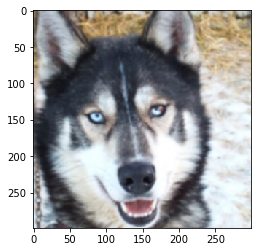

In [9]:
#Top 5 predictions for our image
images = transform_img_fn(['./dogs.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = predict_fn(images)
for x in preds.argsort()[0][-5:]:
    print(x, names[x], preds[0,x])

In [10]:
image = images[0]

## Explanation

In [28]:
from lime import lime_image
import time

In [35]:
explainer = lime_image.LimeImageExplainer()

In [36]:
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image, predict_fn, top_labels=1001, hide_color=0, num_samples=1000)
print(time.time() - tmp)

161.4360761642456


In [37]:
from skimage.segmentation import mark_boundaries

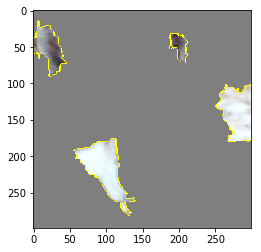

In [39]:
#Eskimo Dog
temp, mask = explanation.get_image_and_mask(249, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

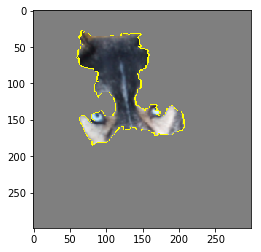

In [32]:
#Siberian Husky
temp, mask = explanation.get_image_and_mask(251, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))